In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from utils import plot_learning_curve

In [2]:
class TwoInputsNet(nn.Module):
    # ****
    # tengo que revisar mejor sobre los channels y toda esta locura porque hay algo raro. sobretodo en la parte de los filtros.
    
    # revisa que todas tus dimensiones esten correctas.
    # ****
    def __init__(self, lr, in_channels, out_channels, kernel_size, input_dims, fc1_dims, fc2_dims, n_actions):
        super(TwoInputsNet, self).__init__()
        self.conv_open = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_high = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_low = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_close = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_volume = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.fc_state = nn.Linear(2, 2)
        
        self.fc1 = nn.Linear(input_dims, fc1_dims) #input dims is the sum of all outputs of the conv layers.
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr = lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        
        # Open High Low Close Volume in that order (also for the numpy array)
        # input6 son dos nodos de input para saber si el agente ha comprado/vendido y en cuanto.
    def forward(self, input1, input2, input3, input4, input5, input6):
        c1 = self.conv_open(input1.unsqueeze(dim = 1))
        c2 = self.conv_high(input2.unsqueeze(dim = 1))
        c3 = self.conv_low(input3.unsqueeze(dim = 1))
        c4 = self.conv_close(input4.unsqueeze(dim = 1))
        c5 = self.conv_volume(input5.unsqueeze(dim = 1))
        f1 = self.fc_state(input6)
        
        # now we can reshape to 2D and concat them
        combined = T.cat((c1.view(c1.size(0), -1), 
                          c2.view(c2.size(0), -1),
                          c3.view(c3.size(0), -1),
                          c4.view(c4.size(0), -1),
                          c5.view(c5.size(0), -1),
                          f1.view(f1.size(0), -1)), dim=1)
        
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        
        return actions
    
class Agent():
    # ***hyperparameters
    def __init__(self, gamma, epsilon, lr, input_dims1, input_dims2, batch_size, n_actions,
                max_mem_size = 100000, eps_end=0.01, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        # self.Q_eval = DeepQNetwork(self.lr, n_actions = n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)
        # (self, lr, in_channels, out_channels, kernel_size, input_dims, fc1_dims, fc2_dims, n_actions)
        # en otras parabras (learning rate, cantidad de filtros de entrada, cantidad de filtros de salida, tamaño del kernel)
        #  ***hyperparameters
        self.Q_eval = TwoInputsNet(self.lr, 1, 4, 3, 562, 128, 128, n_actions)
        #                                             ^
        # tengo que encontrar una forma para hacer que se haga el tamaño del fc layer automaticamente
        
        # ***
        # tengo que reviar si el replay memory esta funcionando correctamente, sobre todo el *input_dims
        # as of now I checked the state_memory shape (10000, 30, 5) and it looks correct
        # ***
        self.state_memory = np.zeros((self.mem_size, *input_dims1), dtype = np.float32)
        self.state_memory2 = np.zeros((self.mem_size, *input_dims2), dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims1), dtype=np.float32)
        self.new_state_memory2 = np.zeros((self.mem_size, *input_dims2), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state[0]
        self.state_memory2[index] = state[1]
        self.new_state_memory[index] = state_[0]
        self.new_state_memory2[index] = state_[1]
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # aqui tuve que separar la observacion en las 2 partes y transformarlas a pytorch tensor. 
            # no se si es lo mejor, pero sirve asi que...
            
            state = T.tensor([observation[0]]).to(self.Q_eval.device)
            state2 = T.tensor([observation[1]]).to(self.Q_eval.device)
#             print(state)
            actions = self.Q_eval.forward(state[:,:,0], 
                                          state[:,:,1], 
                                          state[:,:,2], 
                                          state[:,:,3], 
                                          state[:,:,4],
                                          state2[:])
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        state_batch2 = T.tensor(self.state_memory2[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        new_state_batch2 = T.tensor(self.new_state_memory2[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]

        q_eval = self.Q_eval.forward(state_batch[:,:,0], 
                                     state_batch[:,:,1], 
                                     state_batch[:,:,2], 
                                     state_batch[:,:,3], 
                                     state_batch[:,:,4],
                                     state_batch2[:])[batch_index, action_batch]
    
        q_next = self.Q_eval.forward(new_state_batch[:,:,0], 
                                     new_state_batch[:,:,1], 
                                     new_state_batch[:,:,2], 
                                     new_state_batch[:,:,3], 
                                     new_state_batch[:,:,4],
                                     new_state_batch2[:])
        q_next[terminal_batch] = 0.0
        
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                        else self.eps_min


The episode ran for 4 timesteps.
episode 0 score 0.00 average score 0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 1 score 0.00 average score 0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 2 score -0.00 average score 0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 3 score 0.00 average score 0.00 epsilon 1.00
The episode ran for 5 timesteps.
episode 4 score -0.01 average score -0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 5 score -0.01 average score -0.00 epsilon 1.00
The episode ran for 3 timesteps.
episode 6 score -0.00 average score -0.00 epsilon 1.00
The episode ran for 2 timesteps.
episode 7 score 0.00 average score -0.00 epsilon 1.00
The episode ran for 2 timesteps.
episode 8 score -0.00 average score -0.00 epsilon 1.00
The episode ran for 2 timesteps.
episode 9 score 0.01 average score -0.00 epsilon 1.00
The episode ran for 2 timesteps.
episode 10 score -0.00 average score -0.00 epsilon 1.00
The episode ran for 6 timesteps.
episode

The episode ran for 3 timesteps.
episode 94 score 0.01 average score -0.00 epsilon 0.84
The episode ran for 5 timesteps.
episode 95 score 0.03 average score -0.00 epsilon 0.84
The episode ran for 2 timesteps.
episode 96 score 0.00 average score -0.00 epsilon 0.84
The episode ran for 7 timesteps.
episode 97 score -0.00 average score -0.00 epsilon 0.84
The episode ran for 7 timesteps.
episode 98 score 0.02 average score -0.00 epsilon 0.83
The episode ran for 2 timesteps.
episode 99 score -0.00 average score -0.00 epsilon 0.83
The episode ran for 3 timesteps.
episode 100 score -0.00 average score -0.00 epsilon 0.83
The episode ran for 2 timesteps.
episode 101 score -0.00 average score -0.00 epsilon 0.83
The episode ran for 2 timesteps.
episode 102 score -0.00 average score -0.00 epsilon 0.83
The episode ran for 4 timesteps.
episode 103 score -0.01 average score -0.00 epsilon 0.83
The episode ran for 3 timesteps.
episode 104 score -0.00 average score -0.00 epsilon 0.83
The episode ran for 

The episode ran for 2 timesteps.
episode 189 score -0.00 average score 0.00 epsilon 0.64
The episode ran for 6 timesteps.
episode 190 score 0.00 average score 0.00 epsilon 0.64
The episode ran for 2 timesteps.
episode 191 score 0.01 average score 0.00 epsilon 0.64
The episode ran for 5 timesteps.
episode 192 score 0.00 average score 0.00 epsilon 0.64
The episode ran for 7 timesteps.
episode 193 score -0.01 average score 0.00 epsilon 0.63
The episode ran for 2 timesteps.
episode 194 score -0.00 average score 0.00 epsilon 0.63
The episode ran for 3 timesteps.
episode 195 score 0.01 average score 0.00 epsilon 0.63
The episode ran for 3 timesteps.
episode 196 score -0.02 average score 0.00 epsilon 0.63
The episode ran for 10 timesteps.
episode 197 score -0.00 average score 0.00 epsilon 0.62
The episode ran for 7 timesteps.
episode 198 score -0.01 average score 0.00 epsilon 0.62
The episode ran for 2 timesteps.
episode 199 score 0.00 average score 0.00 epsilon 0.62
The episode ran for 2 tim

The episode ran for 3 timesteps.
episode 281 score -0.00 average score 0.01 epsilon 0.39
The episode ran for 2 timesteps.
episode 282 score -0.01 average score 0.00 epsilon 0.39
The episode ran for 3 timesteps.
episode 283 score 0.00 average score 0.00 epsilon 0.39
The episode ran for 2 timesteps.
episode 284 score -0.00 average score 0.00 epsilon 0.38
The episode ran for 4 timesteps.
episode 285 score -0.00 average score 0.00 epsilon 0.38
The episode ran for 5 timesteps.
episode 286 score 0.02 average score 0.00 epsilon 0.38
The episode ran for 4 timesteps.
episode 287 score 0.00 average score 0.00 epsilon 0.38
The episode ran for 7 timesteps.
episode 288 score 0.01 average score 0.00 epsilon 0.37
The episode ran for 2 timesteps.
episode 289 score -0.00 average score 0.00 epsilon 0.37
The episode ran for 2 timesteps.
episode 290 score 0.00 average score 0.00 epsilon 0.37
The episode ran for 5 timesteps.
episode 291 score -0.00 average score 0.00 epsilon 0.37
The episode ran for 5 time

The episode ran for 9 timesteps.
episode 374 score -0.04 average score 0.02 epsilon 0.04
The episode ran for 11 timesteps.
episode 375 score -0.01 average score 0.02 epsilon 0.04
The episode ran for 14 timesteps.
episode 376 score 0.08 average score 0.02 epsilon 0.03
The episode ran for 7 timesteps.
episode 377 score -0.01 average score 0.02 epsilon 0.03
The episode ran for 6 timesteps.
episode 378 score 0.01 average score 0.02 epsilon 0.02
The episode ran for 4 timesteps.
episode 379 score -0.01 average score 0.02 epsilon 0.02
The episode ran for 6 timesteps.
episode 380 score -0.02 average score 0.02 epsilon 0.02
The episode ran for 8 timesteps.
episode 381 score 0.05 average score 0.02 epsilon 0.01
The episode ran for 16 timesteps.
episode 382 score 0.02 average score 0.02 epsilon 0.01
The episode ran for 16 timesteps.
episode 383 score -0.01 average score 0.02 epsilon 0.01
The episode ran for 3 timesteps.
episode 384 score 0.01 average score 0.02 epsilon 0.01
The episode ran for 14

The episode ran for 20 timesteps.
episode 469 score 0.12 average score 0.02 epsilon 0.01
The episode ran for 6 timesteps.
episode 470 score -0.05 average score 0.02 epsilon 0.01
The episode ran for 2 timesteps.
episode 471 score 0.01 average score 0.02 epsilon 0.01
The episode ran for 7 timesteps.
episode 472 score -0.01 average score 0.02 epsilon 0.01
The episode ran for 17 timesteps.
episode 473 score -0.13 average score 0.02 epsilon 0.01
The episode ran for 4 timesteps.
episode 474 score 0.02 average score 0.02 epsilon 0.01
The episode ran for 4 timesteps.
episode 475 score 0.04 average score 0.02 epsilon 0.01
The episode ran for 3 timesteps.
episode 476 score -0.01 average score 0.02 epsilon 0.01
The episode ran for 5 timesteps.
episode 477 score -0.02 average score 0.02 epsilon 0.01
The episode ran for 9 timesteps.
episode 478 score 0.00 average score 0.02 epsilon 0.01
The episode ran for 17 timesteps.
episode 479 score 0.01 average score 0.02 epsilon 0.01
The episode ran for 5 ti

The episode ran for 7 timesteps.
episode 563 score 0.01 average score 0.03 epsilon 0.01
The episode ran for 3 timesteps.
episode 564 score 0.00 average score 0.03 epsilon 0.01
The episode ran for 13 timesteps.
episode 565 score 0.00 average score 0.03 epsilon 0.01
The episode ran for 14 timesteps.
episode 566 score 0.01 average score 0.03 epsilon 0.01
The episode ran for 2 timesteps.
episode 567 score -0.00 average score 0.03 epsilon 0.01
The episode ran for 3 timesteps.
episode 568 score -0.00 average score 0.03 epsilon 0.01
The episode ran for 3 timesteps.
episode 569 score 0.00 average score 0.02 epsilon 0.01
The episode ran for 4 timesteps.
episode 570 score 0.00 average score 0.02 epsilon 0.01
The episode ran for 6 timesteps.
episode 571 score -0.16 average score 0.02 epsilon 0.01
The episode ran for 2 timesteps.
episode 572 score -0.00 average score 0.02 epsilon 0.01
The episode ran for 2 timesteps.
episode 573 score 0.00 average score 0.02 epsilon 0.01
The episode ran for 12 tim

The episode ran for 6 timesteps.
episode 656 score 0.13 average score 0.00 epsilon 0.01
The episode ran for 4 timesteps.
episode 657 score -0.01 average score 0.00 epsilon 0.01
The episode ran for 2 timesteps.
episode 658 score -0.00 average score 0.00 epsilon 0.01
The episode ran for 2 timesteps.
episode 659 score -0.00 average score 0.00 epsilon 0.01
The episode ran for 5 timesteps.
episode 660 score -0.02 average score -0.00 epsilon 0.01
The episode ran for 8 timesteps.
episode 661 score -0.50 average score -0.01 epsilon 0.01
The episode ran for 5 timesteps.
episode 662 score 0.04 average score -0.01 epsilon 0.01
The episode ran for 4 timesteps.
episode 663 score -0.00 average score -0.01 epsilon 0.01
The episode ran for 2 timesteps.
episode 664 score -0.00 average score -0.01 epsilon 0.01
The episode ran for 12 timesteps.
episode 665 score -0.20 average score -0.01 epsilon 0.01
The episode ran for 5 timesteps.
episode 666 score 0.03 average score -0.01 epsilon 0.01
The episode ran 

The episode ran for 12 timesteps.
episode 748 score 0.00 average score -0.01 epsilon 0.01
The episode ran for 6 timesteps.
episode 749 score -0.00 average score -0.01 epsilon 0.01
The episode ran for 4 timesteps.
episode 750 score -0.01 average score -0.01 epsilon 0.01
The episode ran for 15 timesteps.
episode 751 score 0.02 average score -0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 752 score 0.03 average score -0.01 epsilon 0.01
The episode ran for 3 timesteps.
episode 753 score 0.00 average score -0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 754 score 0.00 average score -0.01 epsilon 0.01
The episode ran for 2 timesteps.
episode 755 score 0.00 average score -0.01 epsilon 0.01
The episode ran for 6 timesteps.
episode 756 score -0.01 average score -0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 757 score 0.06 average score -0.01 epsilon 0.01
The episode ran for 4 timesteps.
episode 758 score -0.05 average score -0.01 epsilon 0.01
The episode ran

The episode ran for 13 timesteps.
episode 840 score 0.01 average score 0.00 epsilon 0.01
The episode ran for 12 timesteps.
episode 841 score 0.00 average score 0.00 epsilon 0.01
The episode ran for 9 timesteps.
episode 842 score 0.05 average score 0.00 epsilon 0.01
The episode ran for 25 timesteps.
episode 843 score 0.07 average score 0.00 epsilon 0.01
The episode ran for 4 timesteps.
episode 844 score -0.00 average score 0.00 epsilon 0.01
The episode ran for 8 timesteps.
episode 845 score 0.00 average score 0.00 epsilon 0.01
The episode ran for 20 timesteps.
episode 846 score -0.23 average score 0.00 epsilon 0.01
The episode ran for 2 timesteps.
episode 847 score -0.01 average score 0.00 epsilon 0.01
The episode ran for 6 timesteps.
episode 848 score -0.01 average score 0.00 epsilon 0.01
The episode ran for 4 timesteps.
episode 849 score -0.01 average score 0.00 epsilon 0.01
The episode ran for 2 timesteps.
episode 850 score -0.01 average score 0.00 epsilon 0.01
The episode ran for 9 

The episode ran for 24 timesteps.
episode 934 score -0.17 average score -0.02 epsilon 0.01
The episode ran for 5 timesteps.
episode 935 score -0.01 average score -0.02 epsilon 0.01
The episode ran for 15 timesteps.
episode 936 score -0.01 average score -0.02 epsilon 0.01
The episode ran for 2 timesteps.
episode 937 score -0.00 average score -0.02 epsilon 0.01
The episode ran for 2 timesteps.
episode 938 score -0.00 average score -0.02 epsilon 0.01
The episode ran for 3 timesteps.
episode 939 score -0.01 average score -0.02 epsilon 0.01
The episode ran for 2 timesteps.
episode 940 score 0.00 average score -0.02 epsilon 0.01
The episode ran for 4 timesteps.
episode 941 score 0.03 average score -0.02 epsilon 0.01
The episode ran for 5 timesteps.
episode 942 score 0.01 average score -0.02 epsilon 0.01
The episode ran for 13 timesteps.
episode 943 score -0.01 average score -0.02 epsilon 0.01
The episode ran for 12 timesteps.
episode 944 score 0.00 average score -0.02 epsilon 0.01
The episod

The episode ran for 3 timesteps.
episode 1028 score -0.00 average score -0.01 epsilon 0.01
The episode ran for 5 timesteps.
episode 1029 score -0.03 average score -0.01 epsilon 0.01
The episode ran for 3 timesteps.
episode 1030 score 0.00 average score -0.01 epsilon 0.01
The episode ran for 32 timesteps.
episode 1031 score 0.30 average score -0.01 epsilon 0.01
The episode ran for 5 timesteps.
episode 1032 score 0.00 average score -0.01 epsilon 0.01
The episode ran for 16 timesteps.
episode 1033 score -0.00 average score -0.01 epsilon 0.01
The episode ran for 6 timesteps.
episode 1034 score -0.12 average score -0.01 epsilon 0.01
The episode ran for 14 timesteps.
episode 1035 score -0.25 average score -0.01 epsilon 0.01
The episode ran for 4 timesteps.
episode 1036 score -0.02 average score -0.01 epsilon 0.01
The episode ran for 3 timesteps.
episode 1037 score 0.00 average score -0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 1038 score -0.03 average score -0.01 epsilon 0.01


The episode ran for 16 timesteps.
episode 1119 score -0.02 average score 0.05 epsilon 0.01
The episode ran for 20 timesteps.
episode 1120 score -0.09 average score 0.05 epsilon 0.01
The episode ran for 19 timesteps.
episode 1121 score -0.66 average score 0.04 epsilon 0.01
The episode ran for 8 timesteps.
episode 1122 score -0.04 average score 0.04 epsilon 0.01
The episode ran for 8 timesteps.
episode 1123 score -0.01 average score 0.04 epsilon 0.01
The episode ran for 8 timesteps.
episode 1124 score -0.00 average score 0.04 epsilon 0.01
The episode ran for 9 timesteps.
episode 1125 score 0.00 average score 0.04 epsilon 0.01
The episode ran for 11 timesteps.
episode 1126 score 0.06 average score 0.04 epsilon 0.01
The episode ran for 35 timesteps.
episode 1127 score 0.18 average score 0.05 epsilon 0.01
The episode ran for 32 timesteps.
episode 1128 score 0.05 average score 0.05 epsilon 0.01
The episode ran for 4 timesteps.
episode 1129 score -0.00 average score 0.05 epsilon 0.01
The epis

The episode ran for 13 timesteps.
episode 1211 score 0.06 average score -0.02 epsilon 0.01
The episode ran for 32 timesteps.
episode 1212 score 0.00 average score -0.02 epsilon 0.01
The episode ran for 5 timesteps.
episode 1213 score 0.02 average score -0.02 epsilon 0.01
The episode ran for 8 timesteps.
episode 1214 score -0.09 average score -0.02 epsilon 0.01
The episode ran for 8 timesteps.
episode 1215 score -0.07 average score -0.02 epsilon 0.01
The episode ran for 34 timesteps.
episode 1216 score -0.43 average score -0.03 epsilon 0.01
The episode ran for 3 timesteps.
episode 1217 score -0.01 average score -0.03 epsilon 0.01
The episode ran for 13 timesteps.
episode 1218 score -0.07 average score -0.03 epsilon 0.01
The episode ran for 15 timesteps.
episode 1219 score -0.19 average score -0.03 epsilon 0.01
The episode ran for 2 timesteps.
episode 1220 score -0.00 average score -0.03 epsilon 0.01
The episode ran for 3 timesteps.
episode 1221 score -0.00 average score -0.02 epsilon 0.

The episode ran for 6 timesteps.
episode 1303 score -0.01 average score -0.00 epsilon 0.01
The episode ran for 2 timesteps.
episode 1304 score 0.00 average score -0.00 epsilon 0.01
The episode ran for 7 timesteps.
episode 1305 score -0.01 average score -0.00 epsilon 0.01
The episode ran for 6 timesteps.
episode 1306 score 0.05 average score -0.00 epsilon 0.01
The episode ran for 6 timesteps.
episode 1307 score -0.00 average score -0.00 epsilon 0.01
The episode ran for 12 timesteps.
episode 1308 score -0.03 average score -0.00 epsilon 0.01
The episode ran for 5 timesteps.
episode 1309 score 0.00 average score -0.00 epsilon 0.01
The episode ran for 2 timesteps.
episode 1310 score -0.00 average score -0.00 epsilon 0.01
The episode ran for 9 timesteps.
episode 1311 score 0.00 average score -0.00 epsilon 0.01
The episode ran for 4 timesteps.
episode 1312 score 0.00 average score -0.00 epsilon 0.01
The episode ran for 4 timesteps.
episode 1313 score -0.01 average score -0.00 epsilon 0.01
The

The episode ran for 20 timesteps.
episode 1395 score 0.26 average score 0.01 epsilon 0.01
The episode ran for 2 timesteps.
episode 1396 score 0.00 average score 0.01 epsilon 0.01
The episode ran for 3 timesteps.
episode 1397 score 0.01 average score 0.01 epsilon 0.01
The episode ran for 18 timesteps.
episode 1398 score -0.23 average score 0.00 epsilon 0.01
The episode ran for 13 timesteps.
episode 1399 score 0.12 average score 0.01 epsilon 0.01
The episode ran for 4 timesteps.
episode 1400 score -0.00 average score 0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 1401 score -0.00 average score 0.01 epsilon 0.01
The episode ran for 2 timesteps.
episode 1402 score -0.00 average score 0.01 epsilon 0.01
The episode ran for 9 timesteps.
episode 1403 score -0.02 average score 0.01 epsilon 0.01
The episode ran for 2 timesteps.
episode 1404 score -0.00 average score 0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 1405 score 0.03 average score 0.01 epsilon 0.01
The episode 

The episode ran for 13 timesteps.
episode 1488 score -0.05 average score 0.01 epsilon 0.01
The episode ran for 16 timesteps.
episode 1489 score -0.09 average score 0.01 epsilon 0.01
The episode ran for 8 timesteps.
episode 1490 score -0.01 average score 0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 1491 score 0.02 average score 0.01 epsilon 0.01
The episode ran for 51 timesteps.
episode 1492 score 0.07 average score 0.01 epsilon 0.01
The episode ran for 17 timesteps.
episode 1493 score -0.07 average score 0.01 epsilon 0.01
The episode ran for 10 timesteps.
episode 1494 score 0.01 average score 0.01 epsilon 0.01
The episode ran for 5 timesteps.
episode 1495 score 0.02 average score 0.00 epsilon 0.01
The episode ran for 6 timesteps.
episode 1496 score -0.01 average score 0.00 epsilon 0.01
The episode ran for 3 timesteps.
episode 1497 score 0.00 average score 0.00 epsilon 0.01
The episode ran for 15 timesteps.
episode 1498 score -0.01 average score 0.01 epsilon 0.01
The episo

The episode ran for 96 timesteps.
episode 1583 score 1.37 average score 0.05 epsilon 0.01
The episode ran for 4 timesteps.
episode 1584 score 0.00 average score 0.05 epsilon 0.01
The episode ran for 8 timesteps.
episode 1585 score -0.01 average score 0.05 epsilon 0.01
The episode ran for 8 timesteps.
episode 1586 score 0.02 average score 0.05 epsilon 0.01
The episode ran for 7 timesteps.
episode 1587 score -0.02 average score 0.05 epsilon 0.01
The episode ran for 15 timesteps.
episode 1588 score 0.01 average score 0.05 epsilon 0.01
The episode ran for 5 timesteps.
episode 1589 score -0.12 average score 0.05 epsilon 0.01
The episode ran for 39 timesteps.
episode 1590 score -0.03 average score 0.05 epsilon 0.01
The episode ran for 5 timesteps.
episode 1591 score 0.00 average score 0.05 epsilon 0.01
The episode ran for 43 timesteps.
episode 1592 score -0.05 average score 0.05 epsilon 0.01
The episode ran for 2 timesteps.
episode 1593 score -0.01 average score 0.05 epsilon 0.01
The episode

The episode ran for 36 timesteps.
episode 1674 score -0.24 average score -0.01 epsilon 0.01
The episode ran for 23 timesteps.
episode 1675 score -0.05 average score -0.01 epsilon 0.01
The episode ran for 20 timesteps.
episode 1676 score 0.02 average score -0.01 epsilon 0.01
The episode ran for 42 timesteps.
episode 1677 score -0.33 average score -0.01 epsilon 0.01
The episode ran for 11 timesteps.
episode 1678 score -0.04 average score -0.02 epsilon 0.01
The episode ran for 3 timesteps.
episode 1679 score -0.01 average score -0.01 epsilon 0.01
The episode ran for 46 timesteps.
episode 1680 score 0.43 average score -0.01 epsilon 0.01
The episode ran for 4 timesteps.
episode 1681 score -0.00 average score -0.01 epsilon 0.01
The episode ran for 5 timesteps.
episode 1682 score -0.01 average score -0.01 epsilon 0.01
The episode ran for 7 timesteps.
episode 1683 score 0.01 average score -0.02 epsilon 0.01
The episode ran for 26 timesteps.
episode 1684 score -0.03 average score -0.02 epsilon 

The episode ran for 4 timesteps.
episode 1764 score 0.01 average score -0.01 epsilon 0.01
The episode ran for 98 timesteps.
episode 1765 score -0.76 average score -0.02 epsilon 0.01
The episode ran for 7 timesteps.
episode 1766 score 0.00 average score -0.02 epsilon 0.01
The episode ran for 9 timesteps.
episode 1767 score -0.07 average score -0.02 epsilon 0.01
The episode ran for 6 timesteps.
episode 1768 score 0.02 average score -0.02 epsilon 0.01
The episode ran for 21 timesteps.
episode 1769 score -0.10 average score -0.02 epsilon 0.01
The episode ran for 2 timesteps.
episode 1770 score -0.00 average score -0.02 epsilon 0.01
The episode ran for 14 timesteps.
episode 1771 score -0.01 average score -0.02 epsilon 0.01
The episode ran for 10 timesteps.
episode 1772 score -0.03 average score -0.03 epsilon 0.01
The episode ran for 57 timesteps.
episode 1773 score -0.42 average score -0.03 epsilon 0.01
The episode ran for 5 timesteps.
episode 1774 score 0.01 average score -0.03 epsilon 0.0

The episode ran for 26 timesteps.
episode 1854 score 0.69 average score -0.47 epsilon 0.01
The episode ran for 572 timesteps.
episode 1855 score -24.93 average score -0.72 epsilon 0.01
The episode ran for 38 timesteps.
episode 1856 score 0.34 average score -0.72 epsilon 0.01
The episode ran for 44 timesteps.
episode 1857 score -0.36 average score -0.72 epsilon 0.01
The episode ran for 3 timesteps.
episode 1858 score -0.00 average score -0.72 epsilon 0.01
The episode ran for 44 timesteps.
episode 1859 score 0.04 average score -0.72 epsilon 0.01
The episode ran for 26 timesteps.
episode 1860 score -0.72 average score -0.73 epsilon 0.01
The episode ran for 10 timesteps.
episode 1861 score 0.08 average score -0.73 epsilon 0.01
The episode ran for 18 timesteps.
episode 1862 score 0.26 average score -0.72 epsilon 0.01
The episode ran for 47 timesteps.
episode 1863 score 0.07 average score -0.72 epsilon 0.01
The episode ran for 133 timesteps.
episode 1864 score -3.01 average score -0.75 epsil

episode 1944 score -0.00 average score -0.48 epsilon 0.01
The episode ran for 21 timesteps.
episode 1945 score 0.02 average score -0.51 epsilon 0.01
The episode ran for 5 timesteps.
episode 1946 score -0.02 average score -0.38 epsilon 0.01
The episode ran for 65 timesteps.
episode 1947 score 0.89 average score -0.38 epsilon 0.01
The episode ran for 35 timesteps.
episode 1948 score 0.02 average score 0.01 epsilon 0.01
The episode ran for 56 timesteps.
episode 1949 score 0.62 average score 0.01 epsilon 0.01
The episode ran for 128 timesteps.
episode 1950 score -3.95 average score -0.02 epsilon 0.01
The episode ran for 70 timesteps.
episode 1951 score 2.67 average score -0.05 epsilon 0.01
The episode ran for 47 timesteps.
episode 1952 score -0.38 average score -0.05 epsilon 0.01
The episode ran for 39 timesteps.
episode 1953 score -0.35 average score -0.01 epsilon 0.01
The episode ran for 296 timesteps.
episode 1954 score 31.62 average score 0.30 epsilon 0.01
The episode ran for 47 timest

The episode ran for 89 timesteps.
episode 2035 score 3.36 average score 0.67 epsilon 0.01
The episode ran for 2 timesteps.
episode 2036 score 0.01 average score 0.68 epsilon 0.01
The episode ran for 242 timesteps.
episode 2037 score 19.07 average score 0.87 epsilon 0.01
The episode ran for 39 timesteps.
episode 2038 score -0.08 average score 0.87 epsilon 0.01
The episode ran for 49 timesteps.
episode 2039 score -1.20 average score 0.87 epsilon 0.01
The episode ran for 90 timesteps.
episode 2040 score 9.17 average score 0.95 epsilon 0.01
The episode ran for 71 timesteps.
episode 2041 score 1.42 average score 0.91 epsilon 0.01
The episode ran for 28 timesteps.
episode 2042 score -0.06 average score 0.91 epsilon 0.01
The episode ran for 102 timesteps.
episode 2043 score -1.90 average score 0.90 epsilon 0.01
The episode ran for 98 timesteps.
episode 2044 score 0.85 average score 0.91 epsilon 0.01
The episode ran for 135 timesteps.
episode 2045 score 4.04 average score 0.95 epsilon 0.01
The

The episode ran for 30 timesteps.
episode 2126 score 0.12 average score 0.24 epsilon 0.01
The episode ran for 61 timesteps.
episode 2127 score 0.68 average score 0.25 epsilon 0.01
The episode ran for 46 timesteps.
episode 2128 score -0.17 average score 0.27 epsilon 0.01
The episode ran for 34 timesteps.
episode 2129 score 0.34 average score 0.46 epsilon 0.01
The episode ran for 120 timesteps.
episode 2130 score 1.30 average score 0.49 epsilon 0.01
The episode ran for 24 timesteps.
episode 2131 score 0.52 average score 0.52 epsilon 0.01
The episode ran for 30 timesteps.
episode 2132 score 0.48 average score 0.52 epsilon 0.01
The episode ran for 30 timesteps.
episode 2133 score -0.39 average score 0.51 epsilon 0.01
The episode ran for 176 timesteps.
episode 2134 score 5.83 average score 0.61 epsilon 0.01
The episode ran for 146 timesteps.
episode 2135 score -1.39 average score 0.56 epsilon 0.01
The episode ran for 9 timesteps.
episode 2136 score 0.05 average score 0.56 epsilon 0.01
The e

The episode ran for 35 timesteps.
episode 2216 score 1.13 average score -0.16 epsilon 0.01
The episode ran for 71 timesteps.
episode 2217 score -0.96 average score -0.17 epsilon 0.01
The episode ran for 30 timesteps.
episode 2218 score 0.24 average score -0.16 epsilon 0.01
The episode ran for 5 timesteps.
episode 2219 score 0.03 average score -0.16 epsilon 0.01
The episode ran for 6 timesteps.
episode 2220 score 0.25 average score -0.16 epsilon 0.01
The episode ran for 34 timesteps.
episode 2221 score -0.39 average score -0.16 epsilon 0.01
The episode ran for 177 timesteps.
episode 2222 score -10.16 average score -0.27 epsilon 0.01
The episode ran for 2 timesteps.
episode 2223 score 0.00 average score -0.27 epsilon 0.01
The episode ran for 11 timesteps.
episode 2224 score 0.03 average score -0.27 epsilon 0.01
The episode ran for 9 timesteps.
episode 2225 score 0.04 average score -0.27 epsilon 0.01
The episode ran for 22 timesteps.
episode 2226 score 0.61 average score -0.26 epsilon 0.0

The episode ran for 50 timesteps.
episode 2306 score 1.36 average score -0.56 epsilon 0.01
The episode ran for 68 timesteps.
episode 2307 score -1.34 average score -0.54 epsilon 0.01
The episode ran for 38 timesteps.
episode 2308 score 1.06 average score -0.49 epsilon 0.01
The episode ran for 59 timesteps.
episode 2309 score -0.10 average score -0.59 epsilon 0.01
The episode ran for 22 timesteps.
episode 2310 score 0.14 average score -0.59 epsilon 0.01
The episode ran for 135 timesteps.
episode 2311 score 2.65 average score -0.10 epsilon 0.01
The episode ran for 130 timesteps.
episode 2312 score -2.69 average score -0.22 epsilon 0.01
The episode ran for 20 timesteps.
episode 2313 score 0.31 average score -0.29 epsilon 0.01
The episode ran for 57 timesteps.
episode 2314 score 0.40 average score -0.46 epsilon 0.01
The episode ran for 16 timesteps.
episode 2315 score -0.06 average score -0.46 epsilon 0.01
The episode ran for 16 timesteps.
episode 2316 score 0.14 average score -0.47 epsilo

The episode ran for 130 timesteps.
episode 2396 score -4.09 average score -0.18 epsilon 0.01
The episode ran for 198 timesteps.
episode 2397 score -12.57 average score -0.32 epsilon 0.01
The episode ran for 160 timesteps.
episode 2398 score 20.62 average score -0.06 epsilon 0.01
The episode ran for 22 timesteps.
episode 2399 score -0.22 average score -0.06 epsilon 0.01
The episode ran for 102 timesteps.
episode 2400 score 1.61 average score -0.03 epsilon 0.01
The episode ran for 68 timesteps.
episode 2401 score 0.10 average score -0.03 epsilon 0.01
The episode ran for 55 timesteps.
episode 2402 score 0.25 average score -0.00 epsilon 0.01
The episode ran for 3 timesteps.
episode 2403 score -0.01 average score -0.01 epsilon 0.01
The episode ran for 4 timesteps.
episode 2404 score -0.01 average score -0.01 epsilon 0.01
The episode ran for 45 timesteps.
episode 2405 score 0.34 average score -0.00 epsilon 0.01
The episode ran for 138 timesteps.
episode 2406 score 4.88 average score 0.03 eps

The episode ran for 17 timesteps.
episode 2486 score -0.05 average score 0.28 epsilon 0.01
The episode ran for 70 timesteps.
episode 2487 score 1.41 average score 0.29 epsilon 0.01
The episode ran for 12 timesteps.
episode 2488 score -0.01 average score 0.29 epsilon 0.01
The episode ran for 289 timesteps.
episode 2489 score 32.83 average score 0.64 epsilon 0.01
The episode ran for 5 timesteps.
episode 2490 score 0.00 average score 0.66 epsilon 0.01
The episode ran for 154 timesteps.
episode 2491 score 3.95 average score 0.69 epsilon 0.01
The episode ran for 142 timesteps.
episode 2492 score 1.91 average score 0.71 epsilon 0.01
The episode ran for 5 timesteps.
episode 2493 score 0.03 average score 0.69 epsilon 0.01
The episode ran for 70 timesteps.
episode 2494 score 2.42 average score 0.70 epsilon 0.01
The episode ran for 23 timesteps.
episode 2495 score 0.02 average score 0.71 epsilon 0.01
The episode ran for 53 timesteps.
episode 2496 score 3.05 average score 0.78 epsilon 0.01
The ep

The episode ran for 170 timesteps.
episode 2577 score -15.06 average score 0.32 epsilon 0.01
The episode ran for 112 timesteps.
episode 2578 score 3.88 average score 0.36 epsilon 0.01
The episode ran for 130 timesteps.
episode 2579 score 5.51 average score 0.41 epsilon 0.01
The episode ran for 48 timesteps.
episode 2580 score 0.62 average score 0.42 epsilon 0.01
The episode ran for 252 timesteps.
episode 2581 score -12.02 average score 0.32 epsilon 0.01
The episode ran for 2 timesteps.
episode 2582 score -0.01 average score 0.31 epsilon 0.01
The episode ran for 18 timesteps.
episode 2583 score 0.24 average score 0.31 epsilon 0.01
The episode ran for 145 timesteps.
episode 2584 score 6.18 average score 0.39 epsilon 0.01
The episode ran for 54 timesteps.
episode 2585 score -0.75 average score 0.49 epsilon 0.01
The episode ran for 11 timesteps.
episode 2586 score 0.16 average score 0.50 epsilon 0.01
The episode ran for 16 timesteps.
episode 2587 score -0.09 average score 0.48 epsilon 0.01

The episode ran for 35 timesteps.
episode 2667 score 0.86 average score 0.20 epsilon 0.01
The episode ran for 78 timesteps.
episode 2668 score 2.50 average score 0.18 epsilon 0.01
The episode ran for 309 timesteps.
episode 2669 score -4.31 average score 0.05 epsilon 0.01
The episode ran for 11 timesteps.
episode 2670 score -0.03 average score 0.05 epsilon 0.01
The episode ran for 142 timesteps.
episode 2671 score 6.08 average score 0.11 epsilon 0.01
The episode ran for 18 timesteps.
episode 2672 score 0.02 average score 0.11 epsilon 0.01
The episode ran for 136 timesteps.
episode 2673 score 2.58 average score -0.09 epsilon 0.01
The episode ran for 85 timesteps.
episode 2674 score 3.39 average score -0.06 epsilon 0.01
The episode ran for 110 timesteps.
episode 2675 score 1.80 average score -0.02 epsilon 0.01
The episode ran for 7 timesteps.
episode 2676 score -0.11 average score -0.04 epsilon 0.01
The episode ran for 103 timesteps.
episode 2677 score 6.55 average score 0.18 epsilon 0.01

The episode ran for 15 timesteps.
episode 2758 score 0.02 average score -0.05 epsilon 0.01
The episode ran for 122 timesteps.
episode 2759 score 12.42 average score 0.07 epsilon 0.01
The episode ran for 47 timesteps.
episode 2760 score -3.66 average score 0.03 epsilon 0.01
The episode ran for 16 timesteps.
episode 2761 score 0.01 average score 0.03 epsilon 0.01
The episode ran for 49 timesteps.
episode 2762 score -0.26 average score 0.04 epsilon 0.01
The episode ran for 236 timesteps.
episode 2763 score 7.98 average score 0.13 epsilon 0.01
The episode ran for 152 timesteps.
episode 2764 score 10.80 average score 0.22 epsilon 0.01
The episode ran for 48 timesteps.
episode 2765 score 0.48 average score 0.69 epsilon 0.01
The episode ran for 39 timesteps.
episode 2766 score 0.18 average score 0.72 epsilon 0.01
The episode ran for 43 timesteps.
episode 2767 score -0.31 average score 0.70 epsilon 0.01
The episode ran for 195 timesteps.
episode 2768 score 19.67 average score 0.88 epsilon 0.01

The episode ran for 21 timesteps.
episode 2848 score -0.05 average score -0.17 epsilon 0.01
The episode ran for 23 timesteps.
episode 2849 score 0.32 average score -0.19 epsilon 0.01
The episode ran for 209 timesteps.
episode 2850 score -5.81 average score -0.27 epsilon 0.01
The episode ran for 34 timesteps.
episode 2851 score -0.38 average score -0.31 epsilon 0.01
The episode ran for 121 timesteps.
episode 2852 score -3.05 average score -0.34 epsilon 0.01
The episode ran for 431 timesteps.
episode 2853 score 54.78 average score 0.18 epsilon 0.01
The episode ran for 11 timesteps.
episode 2854 score 0.02 average score 0.33 epsilon 0.01
The episode ran for 5 timesteps.
episode 2855 score 0.01 average score 0.34 epsilon 0.01
The episode ran for 123 timesteps.
episode 2856 score -1.02 average score 0.33 epsilon 0.01
The episode ran for 55 timesteps.
episode 2857 score 1.78 average score 0.35 epsilon 0.01
The episode ran for 67 timesteps.
episode 2858 score 0.97 average score 0.36 epsilon 0

The episode ran for 66 timesteps.
episode 2938 score -0.07 average score 0.57 epsilon 0.01
The episode ran for 57 timesteps.
episode 2939 score 0.36 average score 0.57 epsilon 0.01
The episode ran for 239 timesteps.
episode 2940 score -2.71 average score 0.55 epsilon 0.01
The episode ran for 102 timesteps.
episode 2941 score -7.12 average score 0.37 epsilon 0.01
The episode ran for 56 timesteps.
episode 2942 score 0.91 average score 0.34 epsilon 0.01
The episode ran for 174 timesteps.
episode 2943 score -9.13 average score 0.32 epsilon 0.01
The episode ran for 80 timesteps.
episode 2944 score -2.64 average score 0.29 epsilon 0.01
The episode ran for 25 timesteps.
episode 2945 score 0.22 average score 0.29 epsilon 0.01
The episode ran for 113 timesteps.
episode 2946 score -7.06 average score 0.22 epsilon 0.01
The episode ran for 14 timesteps.
episode 2947 score -0.09 average score 0.23 epsilon 0.01
The episode ran for 179 timesteps.
episode 2948 score 0.93 average score 0.24 epsilon 0.0

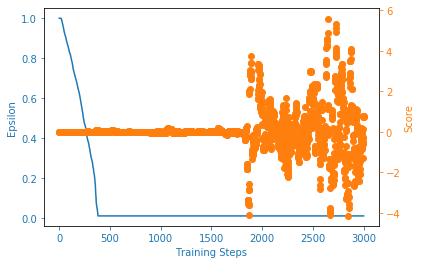

In [6]:
from environment import environment

historical_data = pd.read_csv(r'C:\Users\ratatosck\Desktop\pythonScripts\TradeBot\HistoricalData\EURUSD15.csv', sep='\t',header=None)
historical_data.drop(0, axis=1, inplace = True)
historical_data_np = historical_data.to_numpy(dtype = 'float32')

### hyperparameters
observation_size = 30

env = environment(historical_data_np, observation_size)

agent = Agent(gamma = 0.99, epsilon = 1.0, batch_size=64, n_actions = 3, 
             eps_end = 0.01, input_dims1 = [observation_size, 5], input_dims2 = [2], lr=0.001)

###
scores, eps_history = [], []
n_games = 3000

for i in range (n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])

    print('episode', i, 'score %.2f' % score, 
             'average score %.2f' % avg_score,
             'epsilon %.2f'% agent.epsilon)
        
x = [i+1 for i in range(n_games)]
filename = 'results-v2'
plot_learning_curve(x, scores, eps_history, filename)

In [9]:
print(sum(scores))

129.19538140296936


There are a couple of problems right now. first, the training isnt stable. This might be due to many things, there could be some catastrophic forgetting happening here, or it might just be the limit of the vanilla dqn, or it might just be that the environment is too random, or that the reward function is not good enough, maybe a bit of hyperparameter tuning might be good enough to solve the problem.

There are a lot of questions that remain from this implementation: is the experience replay working? is the pipeline working? does the environment work? this will take a while to figure out.

concerning the reward function, maybe giving negative reward when the agent is on the negative on a trade is good, enforcing early stopping through the reward function might be a good idea.

other solutions might involve implementing the target network, hyperparameter tuning, like the observation size, the replay memory size, the neural network size/ arquitecture.

however, there is no doubt that im going to have to try other algorithms.

*I did the sum of the scores, and it seems that it ends up positive. this is an indicator that the algorithm might actually be working? Ill have to test and average over multiple runs to see if this is actually the case. thought this beings up an interesting question, I sort of expected the shape of the graph to be trending towards positive, but now that I think about it it seems obvious that that might never be the case, and its not necessarily a bad thing, you cant expect the algorithm to have a positive trade every time, just like with people, it is normal to have bad trades, but its the average return that determines if the trader is proficient or not. And just like this, you cant expect an algorithm to always have positive returns. in conclusion, the metric for success is not only the shape of the graph, but the overall return from the whole training procedure; by doing the sum of all the scores "sum(scores)" and the higher the number  the better, and then doing an average over multiple training loops.

*There is another idea that has to be investigated, should the agent be always "greedy" when deployed to production or should you always have a non zero epsilon? and should the agent still have a learning call or should you stop learning when the agent is deployed?

*And finally the question of transfer learning, will it be possible? the training environment would have to be very close to the actual production environment for it to work. unless I come up with some revolutionary way to do transfer learning in rl (not likely).